<a href="https://colab.research.google.com/github/lorenzosintini/4YP/blob/master/Models_v2/Conv_VAE_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Import Libraries

In [2]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import random
import time
import os
import sys
from IPython.display import clear_output
import os
import pandas as pd
tf.autograph.set_verbosity(0)

TensorFlow 2.x selected.


#### Import Data and plot it

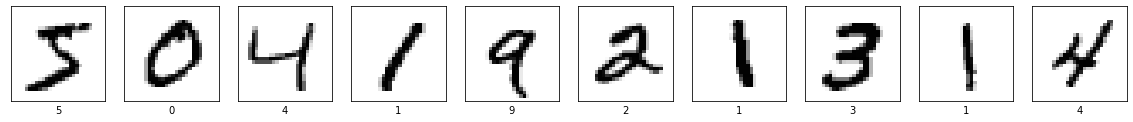

In [3]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

class_names = ['Zero','One', 'Two', 'Three', 'Four', 'Five','Six', 'Seven', 'Eight', 'Nine']
N_image_channels = 1
N_class = len(class_names)
image_shape = x_train.shape[1:3]
input_range = np.amax(x_train)

def plot_images(x_train, y_train, figures_to_plot, pick_random=False, include_labels=True):
    n_rows = np.ceil((figures_to_plot[1])/10)
    plot = plt.figure(figsize=[20,2*n_rows])
    for i in range(figures_to_plot[0],figures_to_plot[1]):
        if pick_random: 
            pic_n = random.randint(0,len(x_train))
        else: pic_n = i
        plt.subplot(n_rows,10,i+1)
        plt.xticks([]); plt.yticks([])
        plt.imshow(x_train[pic_n], cmap=plt.cm.binary)
        if include_labels:
            plt.xlabel(y_train[pic_n])
    plt.show()

plot_images(x_train, y_train, [0,10])

#### Select data, pre-process it and create dataset

In [0]:
def pick_class(x, y, class_n):
    pics = (y == class_n[0])
    for i in range(len(class_n)-1):
      pics = pics + (y == class_n[i+1])
    new_x = x[pics]
    new_y = y[pics]
    return new_x, new_y

def set_pixels_binary(images):
    images = images/input_range
    images[images >= 0.5] = 1.0
    images[images < 0.5] = 0.0
    return images

def make_categorical(y):
    y_cat = tf.keras.utils.to_categorical(y)
    return y_cat

def cut_data(data, data_number):
    data = data[0:data_number]
    return data

def setup_dataset(x_train, y_train, x_test, y_test, chosen_classes=[0,1,2,3,4,5,6,7,8,9], data_number = -1):
  x_train, y_train = pick_class(x_train, y_train, chosen_classes)
  x_test, y_test = pick_class(x_test, y_test, chosen_classes)
  
  x_train = cut_data(x_train, data_number)
  y_train = cut_data(y_train, data_number)

  train_images = set_pixels_binary(x_train)
  test_images = set_pixels_binary(x_test)

  train_images = train_images.reshape(len(y_train), image_shape[0], image_shape[1], N_image_channels).astype('float32')
  test_images = test_images.reshape(len(y_test), image_shape[0], image_shape[1], N_image_channels).astype('float32')

  batch_size = 100
  train_dataset = tf.data.Dataset.from_tensor_slices((train_images)).shuffle(len(y_train)).batch(batch_size)
  test_dataset = tf.data.Dataset.from_tensor_slices((test_images)).shuffle(len(y_test)).batch(batch_size)
  return x_train, y_train, x_test, y_test, train_dataset, test_dataset

#### Create Variational Autoencoder (VAE) Model

In [0]:
class CVAE(tf.keras.Model):
    def __init__(self, z_size):
        super(CVAE, self).__init__()
        self.z_size = z_size
        self.encoder_nn = tf.keras.models.Sequential([ 
                          tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28, 28, 1)),
                          tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
                          tf.keras.layers.Flatten(),
                          tf.keras.layers.Dense(z_size*2)
                          ])

        self.decoder_nn = tf.keras.models.Sequential([
                          tf.keras.layers.Dense(units=24*24*64, activation='relu', input_shape=(z_size,)),
                          tf.keras.layers.Reshape(target_shape=(24, 24, 64)),
                          tf.keras.layers.Conv2DTranspose(32, (3,3), activation='relu'),
                          tf.keras.layers.Conv2DTranspose(1, (3,3)),
                          ])

    def encode(self, x):
        encoder_nn_output = self.encoder_nn(x)
        z_mean, z_logvar = tf.split(encoder_nn_output, num_or_size_splits=2, axis=1)
        return z_mean, z_logvar

    def reparameterize(self, z_mean, z_logvar):
        epsilon = tf.random.normal(shape=z_mean.shape)
        z_sampled = epsilon * tf.exp(z_logvar * 0.5) + z_mean
        return z_sampled
      

    def decode(self, z):
        pixel_output = self.decoder_nn(z)
        pixel_prob = tf.math.sigmoid(pixel_output)
        return pixel_prob

#### Define the loss function 

In [0]:
def calculate_ELBO(model, x):
    z_mean, z_logvar = model.encode(x)
    z = model.reparameterize(z_mean, z_logvar)
    
    pixel_prob = model.decode(z)
    
    logpx_z_pixels = tf.math.log(pixel_prob + 1e-10)*x + tf.math.log(1-pixel_prob + 1e-10)*(1-x)
    logpx_z_images = tf.reduce_sum(logpx_z_pixels, axis=[1, 2, 3])
    logpx_z = tf.reduce_mean (logpx_z_images)
    
    KL_parameters = -0.5 * (1 + z_logvar - (z_mean ** 2.0) - tf.exp(z_logvar))
    KL_vectors = tf.reduce_sum(KL_parameters, axis=1)
    KL = tf.reduce_mean(KL_vectors)
    
    ELBO = (logpx_z - KL)
    
    return -ELBO, logpx_z, KL #Negative because we want to maximise it

In [0]:
def calculate_pixel_squared(model, x):
    z_mean, z_logvar = model.encode(x)
    z = model.reparameterize(z_mean, z_logvar)
    pixel_prob = model.decode(z)
    pixel_squared = np.square(pixel_prob - x)
    pixel_squared = tf.reduce_sum(pixel_squared, axis=[1,2,3])
    pixel_squared = tf.reduce_mean (pixel_squared)
    return pixel_squared

In [0]:
def calculate_ssim(model, x):
  z_mean, z_logvar = model.encode(x)
  z = model.reparameterize(z_mean, z_logvar)
  y = model.decode(z)

  x = tf.convert_to_tensor(x)
  y = tf.convert_to_tensor(y)
  ssim = tf.image.ssim(x[:,:,:,:],y[:,:,:,:], input_range, filter_size=11,filter_sigma=0.1,k1=0.1,k2=0.01)
  ssim = tf.reduce_mean(ssim)
  return (1-ssim)*1000

#### Define the optimizer

In [0]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

#### Define loss metrics

In [0]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.Mean(name='test_loss')

#### Define train and test steps

In [0]:
def train_step(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss,_,_ = calculate_ELBO(model, x)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        train_loss(loss)

def test_step(model, x, optimizer):
    loss,_,_ = calculate_ELBO(model, x)
    test_loss(loss)

#### Generate random image from latent vector

In [0]:
def generate_images(model, z_random, figures_to_plot):
    generated_prob = model.decode(z_random)
    generated_prob = np.squeeze(generated_prob, axis=3)
    plot_images(generated_prob, _, figures_to_plot, include_labels=False)

In [0]:
def train_test_dataset(model, train_dataset, test_dataset, epochs, generate=True):
  plots_per_epoch = 10
  z_random = tf.random.normal(shape=[plots_per_epoch, z_size])
  
  test_ELBO = []
  train_ELBO = []
  epoch_number = []  
  for epoch in range(epochs):
    print('Epoch {}'.format(epoch))
    for train_x in train_dataset: 
      train_step(model, train_x, optimizer)
  
    for test_x in test_dataset:
      test_step(model, test_x, optimizer)
    
    test_ELBO.append(-test_loss.result())
    train_ELBO.append(-train_loss.result())
    epoch_number.append(epoch)
    
    clear_output()
    if generate:
      generate_images(model, z_random, [0,plots_per_epoch])
    plt.plot(epoch_number, test_ELBO, train_ELBO)
    plt.legend(['test','train'])
    plt.title('model')
    plt.show()
  train_loss.reset_states()
  test_loss.reset_states()

#### Train the data

In [0]:
def change_ratio(x, y, chosen_classes, chosen_numbers):
    x_new = np.zeros([0,image_shape[0], image_shape[1]])
    y_new = np.zeros([0])
    n_classes = len(chosen_classes)
    for i in range (n_classes):
        if chosen_classes[i] != -1:
            x_class, y_class = pick_class(x, y, [chosen_classes[i]])
            x_class = cut_data(x_class, chosen_numbers[i])
        y_class = cut_data(y_class, chosen_numbers[i])
        x_new = np.concatenate((x_new, x_class))
        y_new = np.concatenate((y_new, y_class))
    return x_new, y_new

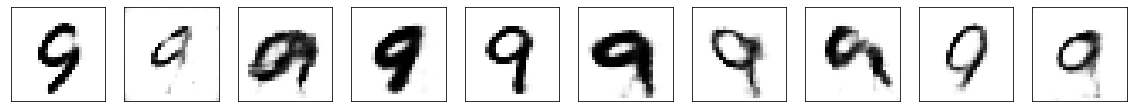

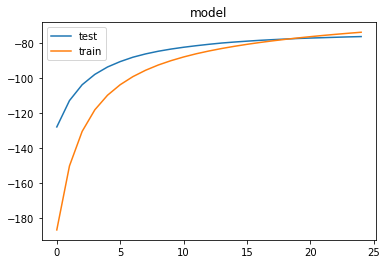

In [15]:
chosen_classes=[0,1,2,3,4,5,6,7,8,9]
chosen_numbers = [5400, 5400, 5400, 5400, 5400, 5400, 5400, 5400, 5400, 5400]
x_train, y_train = change_ratio(x_train, y_train, chosen_classes, chosen_numbers)
chosen_numbers = [850, 850, 850, 850, 850, 850, 850, 850, 850, 850]
x_test, y_test = change_ratio(x_test, y_test, chosen_classes, chosen_numbers)

x_train_0, y_train_0, x_test_0, y_test_0, train_dataset_0, test_dataset_0 = setup_dataset(x_train, y_train, x_test, y_test, chosen_classes=[0])
x_train_1, y_train_1, x_test_1, y_test_1, train_dataset_1, test_dataset_1 = setup_dataset(x_train, y_train, x_test, y_test, chosen_classes=[1])
x_train_2, y_train_2, x_test_2, y_test_2, train_dataset_2, test_dataset_2 = setup_dataset(x_train, y_train, x_test, y_test, chosen_classes=[2])
x_train_3, y_train_3, x_test_3, y_test_3, train_dataset_3, test_dataset_3 = setup_dataset(x_train, y_train, x_test, y_test, chosen_classes=[3])
x_train_4, y_train_4, x_test_4, y_test_4, train_dataset_4, test_dataset_4 = setup_dataset(x_train, y_train, x_test, y_test, chosen_classes=[4])
x_train_5, y_train_5, x_test_5, y_test_5, train_dataset_5, test_dataset_5 = setup_dataset(x_train, y_train, x_test, y_test, chosen_classes=[5])
x_train_6, y_train_6, x_test_6, y_test_6, train_dataset_6, test_dataset_6 = setup_dataset(x_train, y_train, x_test, y_test, chosen_classes=[6])
x_train_7, y_train_7, x_test_7, y_test_7, train_dataset_7, test_dataset_7 = setup_dataset(x_train, y_train, x_test, y_test, chosen_classes=[7])
x_train_8, y_train_8, x_test_8, y_test_8, train_dataset_8, test_dataset_8 = setup_dataset(x_train, y_train, x_test, y_test, chosen_classes=[8])
x_train_9, y_train_9, x_test_9, y_test_9, train_dataset_9, test_dataset_9 = setup_dataset(x_train, y_train, x_test, y_test, chosen_classes=[9])

z_size = 10
model_0 = CVAE(z_size)
model_1 = CVAE(z_size)
model_2 = CVAE(z_size)
model_3 = CVAE(z_size)
model_4 = CVAE(z_size)
model_5 = CVAE(z_size)
model_6 = CVAE(z_size)
model_7 = CVAE(z_size)
model_8 = CVAE(z_size)
model_9 = CVAE(z_size)

model_dict = {'0' : model_0,
              '1' : model_1,
		          '2' : model_2,
              '3' : model_3,
              '4' : model_4,
              '5' : model_5,
              '6' : model_6,
              '7' : model_7,
              '8' : model_8,
              '9' : model_9,}

train_test_dataset(model_0, train_dataset_0, test_dataset_0, 25, generate=True)
train_test_dataset(model_1, train_dataset_1, test_dataset_1, 25, generate=True)
train_test_dataset(model_2, train_dataset_2, test_dataset_2, 25, generate=True)
train_test_dataset(model_3, train_dataset_3, test_dataset_3, 25, generate=True)
train_test_dataset(model_4, train_dataset_4, test_dataset_4, 25, generate=True)
train_test_dataset(model_5, train_dataset_5, test_dataset_5, 25, generate=True)
train_test_dataset(model_6, train_dataset_6, test_dataset_6, 25, generate=True)
train_test_dataset(model_7, train_dataset_7, test_dataset_7, 25, generate=True)
train_test_dataset(model_8, train_dataset_8, test_dataset_8, 25, generate=True)
train_test_dataset(model_9, train_dataset_9, test_dataset_9, 25, generate=True)

In [0]:
#x_train_024, y_train_024, x_test_024, y_test_024, train_dataset_024, test_dataset_024 = setup_dataset(x_train, y_train, x_test, y_test, chosen_classes=[0,2,4])
#z_size = 2
#model_024 = CVAE(z_size)
#train_test_dataset(model_024, train_dataset_024, test_dataset_024, 20, generate=True)

#### Reconstruct images

Original Pictures:


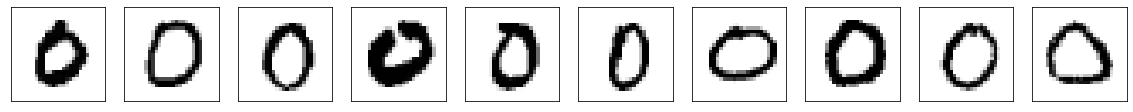

Reconstructed Pictures, with ELBO loss:


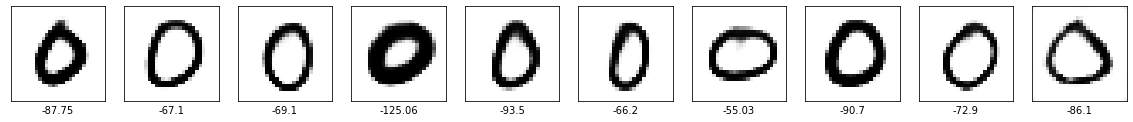

In [17]:
def reconstruct_images(model, images):
    images_n = len(images)
    x = images/input_range
    x[x >= 0.5] = 1.0
    x[x < 0.5] = 0.0
    x = x.reshape(images_n, image_shape[0], image_shape[1], N_image_channels).astype('float32')
    
    z_mean, z_logvar = model.encode(x)
    z = model.reparameterize(z_mean, z_logvar)
    pixel_output = model.decode(z)
    pixel_prob = tf.math.sigmoid(pixel_output)
    pixel_prob = np.squeeze(pixel_prob, axis=3)

    loss = np.empty([images_n])
    for i in range(images_n):
        loss[i],_,_ = calculate_ELBO(model,x[i:i+1])
    loss = loss.astype('float16')
    
    print('Original Pictures:')
    plot_images(images, _, figures_to_plot=[0,images_n], include_labels=False)
    print('Reconstructed Pictures, with ELBO loss:')
    plot_images(pixel_prob, -loss, figures_to_plot=[0,images_n], include_labels=True)

reconstruct_images(model_0, x_test_0[0:10])

#### Visualize the latent space

0 Outliers detected


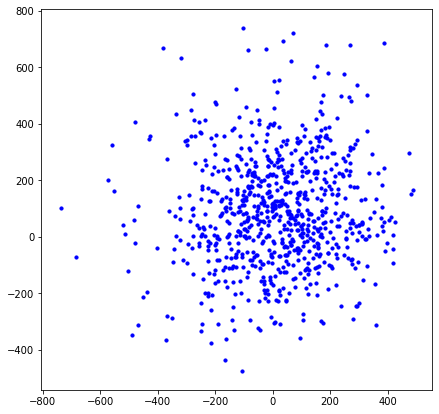

In [0]:
def visualize_latent_space(model, range1, range2, data_x, data_y, a, b):
  plot = plt.figure(figsize=[7,7])
  outliers=0
  for i in range(range1, range2):
    pic_visualize = data_x[i]
    pic_visualize = pic_visualize.reshape(1, image_shape[0], image_shape[1], N_image_channels).astype('float32')
    
    z_mean, z_logvar = model.encode(pic_visualize)
    z = model.reparameterize(z_mean, z_logvar)
    
    if any(z_logvar[:,i]>5 for i in range(z_size)):
      outliers +=1
      continue
      
    if data_y[i] == 0:
      color = 'blue'
    if data_y[i] == 1:
      color = 'orange'
    if data_y[i] == 2:
      color = 'green'
    if data_y[i] == 3:
      color = 'red'
    if data_y[i] == 4:
      color = 'purple'  
    if data_y[i] == 5:
      color = 'brown'
    if data_y[i] == 6:
      color = 'pink'
    if data_y[i] == 7:
      color = 'gray'
    if data_y[i] == 8:
      color = 'black'
    if data_y[i] == 9:
      color = 'yellow'
    plt.scatter(z[:,a],z[:,b], color=color, s=10)
    #plt.xlim([-1000,1000])
    #plt.ylim([-1000,1000])
    #plt.annotate('{}'.format(i),(z[:,a],z[:,b]))
  print('{} Outliers detected'.format(outliers))


visualize_latent_space(model_0, 0,800, x_test_0, y_test_0, 0,1)

#labels = []; 
#for i in range(N_train): labels.append(i)
#plot_images(x_train, labels, [250,300])

#### Check reconstruction performance for untrained classes


Model trained with class 0


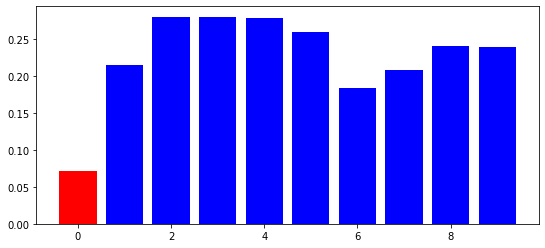

Model trained with class 1


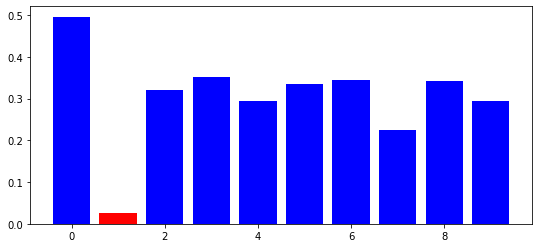

Model trained with class 2


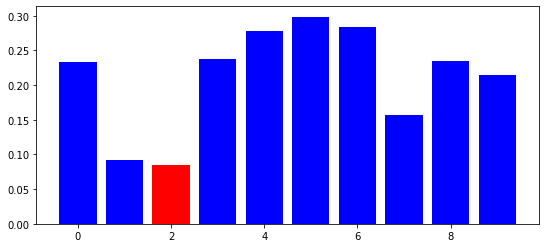

Model trained with class 3


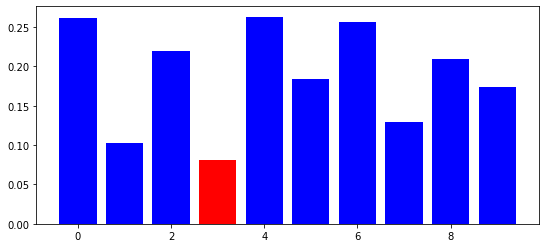

Model trained with class 4


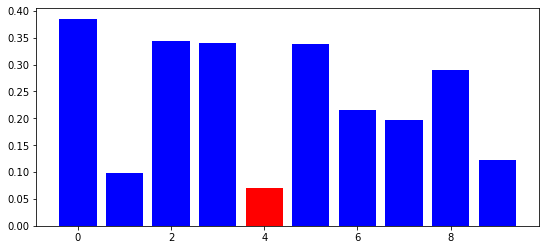

Model trained with class 5


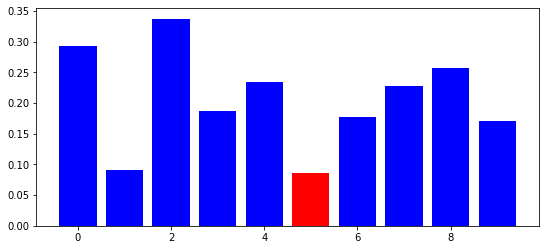

Model trained with class 6


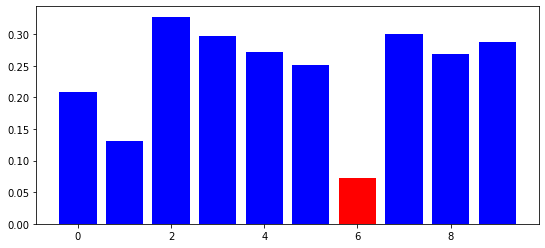

Model trained with class 7


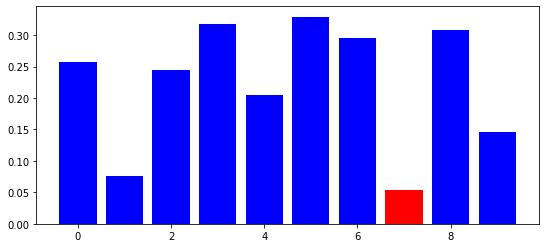

Model trained with class 8


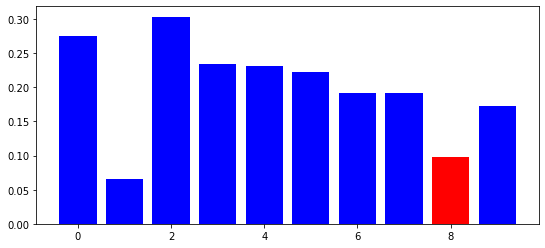

Model trained with class 9


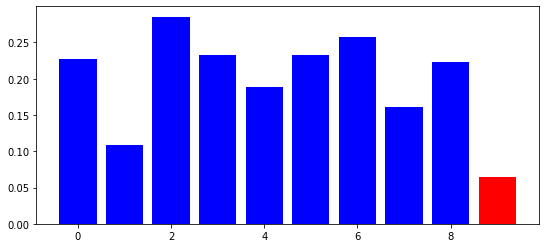

In [18]:
table_of_losses = np.zeros([N_class, N_class])
for i in range(0,N_class):
  model = model_dict[str(i)]
  print('Model trained with class {}'.format(i))
  plt.figure(figsize=[9,4])
  for j in range(N_class):
    test_images = x_test[(y_test==j)]
    test_images = set_pixels_binary(test_images)
    test_images = test_images.reshape(len(test_images), image_shape[0], image_shape[1], N_image_channels).astype('float32')
    #_,loss,_ = calculate_ELBO(model,test_images)
    #loss = -calculate_pixel_squared(model,test_images)
    loss = calculate_ssim(model, test_images)
    table_of_losses[j,i] = loss
    if j==i:
      color='red'
    else:
      color='blue'
    plt.bar(j,loss.numpy(),color=color)
    #print('ELBO loss for class {}: {}'.format(i,loss))
  plt.show()

for i in range(N_class):
    table_of_losses[i,:] = table_of_losses[i,:]/np.min(table_of_losses[i,:])
  

# reconstruct_images(x_test[(y_test==8)][0:10], test_images[(y_test==8)][0:10])

#visualize_latent_space(0,1000, x_train, y_train, 0,1)
#classes_to_pick = [1]
#x_reconstruct_test, y_reconstruct_test = pick_class(x_test, y_test, classes_to_pick)
#visualize_latent_space(0,100, x_reconstruct_test, y_reconstruct_test, 0,1)


#### Classify test images

In [95]:
_, _, x_test_classes, y_test_classes, _, _ = setup_dataset(x_train, y_train, x_test, y_test, chosen_classes=[0,1,2,3,4,5,6,7,8,9])
predicted_class = np.zeros([1,len(x_test_classes)])
predicted_probabilities = np.zeros([len(x_test_classes)*2,10])
for i in range(len(x_test_classes)):
  if not i%10:
    clear_output()
    print('Progress:{}%'.format(100*(i+1)/len(x_test_classes)))
  test_image = x_test_classes[i]/input_range
  test_image[test_image >= 0.5] = 1.0
  test_image[test_image < 0.5] = 0.0
  test_image = test_image.reshape(1, image_shape[0], image_shape[1], N_image_channels).astype('float32')
  
  loss_per_model = np.empty([2,10])
  a = np.empty([2,10])
  for j in range(0,10):
    model = model_dict[str(j)]
    _,loss1,_ = calculate_ELBO(model,test_image)
    loss2 = calculate_ssim(model,test_image)
    #print('ELBO loss for class {}: {}'.format(i,loss))
    loss_per_model[0,j]= -loss1
    loss_per_model[1,j] = loss2
  a[0,:] = loss_per_model[0,:]/np.min(loss_per_model[0,:])
  a[1,:] = loss_per_model[1,:]/np.min(loss_per_model[1,:])
  a = np.multiply(a,-2)
  e_x = np.exp(a)
  predicted_probabilities[2*i,:] = (e_x[0,:] / e_x[0,:].sum())*100
  predicted_probabilities[2*i+1,:] = (e_x[1,:] / e_x[1,:].sum())*100
  #print(predicted_probabilities[2*i:2*i+2,:])
  max_index = np.argmax(predicted_probabilities[2*i:2*i+2,:])
  if max_index < 10:
    predicted_class[0,i] = max_index
  else:
    predicted_class[0,i] = max_index-10
  #predicted_class[0,i] = loss_per_model.index(min(loss_per_model))
  #print(predicted_class[0,i])
print(predicted_class)

Progress:99.89411764705882%
[[0. 0. 0. ... 9. 9. 9.]]


#### Check accuracy and plot misslabeled images

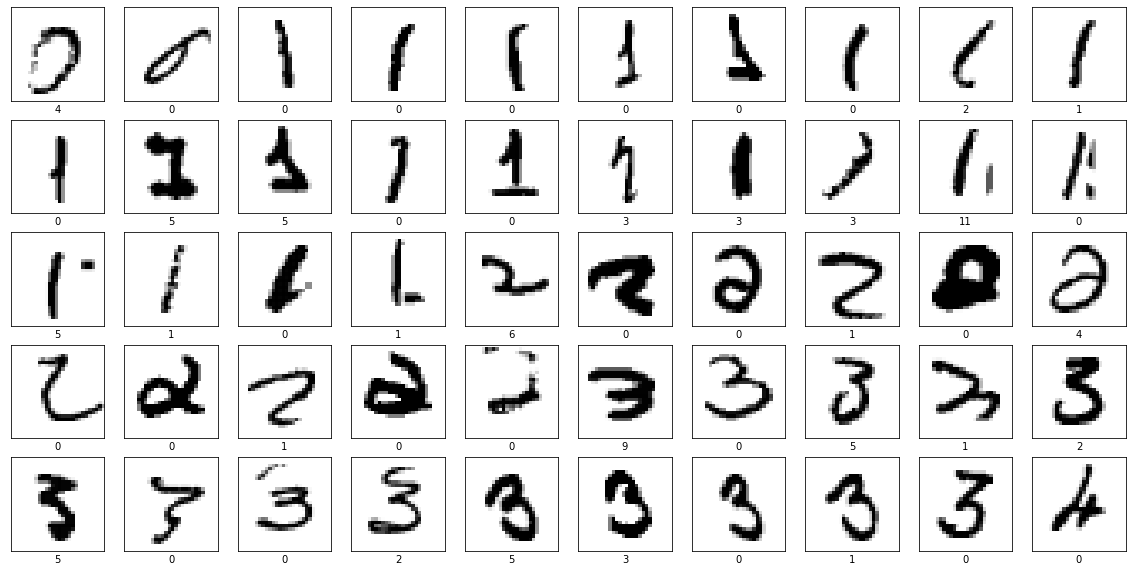

In [96]:
import pandas as pd
predicted_class = predicted_class.astype('int')
y_test_classes = y_test_classes.astype('int')

wrong_guesses = []
table_of_counts = np.zeros([N_class, N_class+1])
for i in range(predicted_class.shape[1]):
    table_of_counts[y_test_classes[i], predicted_class[0,i]]+=1
    if y_test_classes[i] != predicted_class[0,i]:
        wrong_guesses.append(i)
trace_count = table_of_counts.trace().astype('int')
sum_count = table_of_counts.sum().astype('int')
for i in range(N_class):
    accuracy_of_class = 100*table_of_counts[i,i]/np.sum(table_of_counts[i,0:-1])
    table_of_counts[i,-1] = accuracy_of_class.astype('float16')

index = list(str('-') * N_class)
columns = list(str('-') * (N_class+1))
for i in range(N_class):
    index[i]= 'Class '+ str(i)
    columns[i] = '|' + str(i) + '_Counts|'
columns[-1] = 'Percentage'
table = pd.DataFrame.from_records(table_of_counts, index=index, columns=columns)

probabilities = np.zeros([len(wrong_guesses)])
pics_to_plot = list(x_test[i] for i in wrong_guesses)
labels = list(predicted_class[0,i] for i in wrong_guesses)
for i in range(len(wrong_guesses)):
    probabilities[i] = predicted_probabilities[wrong_guesses[i],labels[i]]
    probabilities = probabilities.astype('int')

plot_images(pics_to_plot[0:50], probabilities[0:50], [0,len(labels[0:50])])

all_probabilities = np.zeros([len(x_test_classes)])
for i in range(len(x_test_classes)):
    all_probabilities[i] = predicted_probabilities[i,predicted_class[0,i]]
    all_probabilities = all_probabilities.astype('int')#

#plot_images(x_test_classes[0:50], all_probabilities[0:50], [0,len(labels[0:50])])

In [97]:
print('Correctly labelled pictures:{}/{} -> Accuracy: {}%'.format(trace_count, sum_count, trace_count/sum_count*100))
print('Incorrectly labelled pictures:{}/{} -> Error: {}%'.format(sum_count-trace_count, sum_count, (sum_count-trace_count)/sum_count*100))
table

Correctly labelled pictures:8329/8500 -> Accuracy: 97.98823529411764%
Incorrectly labelled pictures:171/8500 -> Error: 2.011764705882353%


,|0_Counts|,|1_Counts|,|2_Counts|,|3_Counts|,|4_Counts|,|5_Counts|,|6_Counts|,|7_Counts|,|8_Counts|,|9_Counts|,Percentage
Class 0,848.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,99.7500
Class 1,0.0,828.0,5.0,3.0,1.0,2.0,1.0,3.0,7.0,0.0,97.4375
Class 2,4.0,0.0,839.0,1.0,0.0,0.0,1.0,4.0,1.0,0.0,98.6875
Class 3,0.0,0.0,1.0,836.0,0.0,8.0,0.0,2.0,2.0,1.0,98.3750
Class 4,0.0,0.0,0.0,0.0,840.0,0.0,2.0,1.0,2.0,5.0,98.8125
Class 5,0.0,0.0,0.0,7.0,0.0,841.0,1.0,0.0,1.0,0.0,98.9375
Class 6,7.0,2.0,0.0,0.0,4.0,7.0,825.0,0.0,5.0,0.0,97.0625
Class 7,0.0,1.0,4.0,5.0,3.0,0.0,0.0,834.0,1.0,2.0,98.1250
Class 8,0.0,0.0,1.0,9.0,1.0,1.0,1.0,0.0,834.0,3.0,98.1250
Class 9,1.0,0.0,1.0,3.0,23.0,9.0,0.0,4.0,5.0,804.0,94.5625


In [0]:
# Convolutional VAE for each class results in accuracy of 98.16% with z_size = 10
# Convolutional VAE for each class results in accuracy of 89.90% with z_size = 2

In [26]:
index = list(str('-') * N_class)
columns = list(str('-') * (N_class))
for i in range(N_class):
    index[i]= 'Class '+ str(i)
    columns[i] = 'Model ' + str(i)

table_loss = pd.DataFrame.from_records(np.around(table_of_losses, decimals=2), index=index, columns=columns)
table_loss

,Model 0,Model 1,Model 2,Model 3,Model 4,Model 5,Model 6,Model 7,Model 8,Model 9
Class 0,1.00,7.00,3.29,3.70,5.44,4.13,2.94,3.64,3.90,3.21
Class 1,8.64,1.00,3.71,4.11,3.95,3.69,5.28,3.07,2.64,4.37
Class 2,3.32,3.78,1.00,2.59,4.07,3.99,3.87,2.89,3.59,3.38
Class 3,3.45,4.33,2.92,1.00,4.21,2.30,3.67,3.91,2.89,2.87
Class 4,3.98,4.20,3.99,3.76,1.00,3.37,3.89,2.93,3.30,2.70
Class 5,3.00,3.85,3.44,2.11,3.90,1.00,2.90,3.80,2.57,2.68
Class 6,2.55,4.78,3.94,3.57,3.00,2.48,1.00,4.12,2.67,3.58
Class 7,3.91,4.22,2.95,2.43,3.69,4.29,5.65,1.00,3.59,3.02
Class 8,2.45,3.51,2.40,2.14,2.96,2.64,2.75,3.15,1.00,2.27
Class 9,3.71,4.59,3.33,2.70,1.90,2.67,4.47,2.27,2.68,1.00


In [43]:
w_ssim = np.transpose(wrong_guesses)
p_ssim = predicted_probabilities.astype('int')
w2

array([ 629,  634,  668,  853,  856,  890,  924,  960,  967, 1030, 1101,
       1109, 1120, 1156, 1221, 1303, 1335, 1352, 1358, 1375, 1399, 1459,
       1470, 1495, 1548, 1549, 1600, 1624, 1763, 1773, 1775, 1847, 1896,
       1899, 1919, 1969, 1972, 2051, 2057, 2098, 2135, 2149, 2206, 2390,
       2421, 2609, 2644, 2671, 2723, 2793, 2813, 2853, 2855, 2858, 2982,
       3132, 3143, 3144, 3146, 3152, 3295, 3451, 3503, 3523, 3535, 3557,
       3631, 3676, 3693, 3767, 3967, 4144, 4243, 4282, 4295, 4311, 4328,
       4367, 4375, 4404, 4423, 4434, 4487, 4530, 4573, 4594, 4598, 4599,
       4659, 4660, 4789, 4997, 5007, 5089, 5126, 5135, 5139, 5143, 5156,
       5187, 5190, 5253, 5290, 5292, 5336, 5343, 5421, 5429, 5433, 5453,
       5463, 5714, 5743, 5886, 6023, 6052, 6076, 6078, 6079, 6081, 6082,
       6083, 6125, 6150, 6161, 6217, 6327, 6346, 6348, 6361, 6386, 6397,
       6445, 6457, 6488, 6543, 6546, 6559, 6615, 6616, 6704, 6839, 6849,
       6884, 6885, 6901, 6921, 6979, 6998, 7077, 70

In [82]:
w_prob
p_prob
w_ssim
p_ssim

w_both = []
for i in range(len(w_prob)):
    for j in range(len(w_ssim)):
        if w_prob[i]==w_ssim[j]:
            w_both.append(w_prob[i])

w_only = []
w_only.extend(w_prob)
w_only.extend(np.transpose(w_ssim))
for i in range(len(w_both)):
    w_only.remove(w_both[i])
    w_only.remove(w_both[i])

#print(w_prob)
#print(w_ssim)
#print(w_both)
#print(w_only)

for i in range(10):
    print(w_only[i])
    if w_only[i]<840:
        print([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
    if w_only[i]>840 & w_only[i]<2*840:
        print([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
    print(p_prob[w_only[i]])
    print(p_ssim[w_only[i]])

343
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[15  0 16 13  2 15  3  5 15 11]
[20  1 11  7  2 10  6 12 11 14]
907
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[ 0 23  1  4  5  6  1  8 46  1]
[ 0 29  2  4  4 11 11  7 27  0]
953
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[ 0 21  1 18  1 12  0  7 31  3]
[ 0 47  0 15  2  6  0  7 16  2]
1022
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[ 9 12  0  3  6 21 36  3  5  0]
[ 1 41  2  1  7  7 31  4  1  0]
1034
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[ 0 22  4  1  0 28  1  0 39  0]
[ 0 45  0  0  0 18  1  0 32  0]
1083
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[ 0 24  4  8 13  4  1 29  6  6]
[ 0 35  3  4  9  3  1 30  8  2]
1088
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[ 1 19 12 14  2  2  1 17 23  3]
[ 0 28  8 22  0  2  0 18 14  3]
1111
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[ 0 24  0 11  4 24  0  1 25  6]
[ 0 45  2  6  1 18  0  0 21  2]
1168
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[ 0 19  5 12 14  2  0 34  6  5]
[ 0 56 10 10  2  0  0 17  1  0]
1198
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[ 4

In [101]:
np.transpose(w_only)

array([ 343,  907,  953, 1022, 1034, 1083, 1088, 1111, 1168, 1198, 1223,
       1299, 1439, 1546, 1556, 1592, 1595, 1601, 1633, 1769, 2217, 2290,
       2368, 2550, 2717, 2819, 2906, 3115, 3135, 3169, 3431, 3569, 3775,
       4309, 4310, 4646, 5121, 5175, 5241, 5274, 5275, 5342, 5344, 5426,
       5456, 5494, 5538, 5704, 6002, 6018, 6067, 6262, 6284, 6303, 6358,
       6527, 6618, 6619, 6712, 6793, 6821, 6826, 6861, 6893, 7143, 7197,
       7461, 7464, 7530, 7556, 7578, 7650, 7658, 7668, 7696, 7744, 7801,
       7868, 7880, 7881, 7912, 7946, 8038, 8043, 8081, 8089, 8139, 8225,
       8281, 8284, 8285, 8287, 8375, 8427,  668,  853, 1120, 1156, 1221,
       1303, 1352, 1375, 1399, 1548, 1549, 1763, 1773, 1775, 1847, 1972,
       2135, 2206, 2421, 2609, 2644, 2671, 2723, 2793, 2813, 3132, 3143,
       3144, 3295, 3503, 3535, 3676, 3767, 4282, 4295, 4311, 4404, 4423,
       4434, 4487, 4530, 4573, 4594, 4599, 4660, 4997, 5089, 5126, 5143,
       5190, 6052, 6078, 6079, 6081, 6082, 6150, 61

In [102]:
np.transpose(wrong_guesses)

array([ 629,  634,  853,  890,  907,  960,  967,  991, 1022, 1034, 1083,
       1101, 1109, 1120, 1303, 1335, 1352, 1358, 1459, 1470, 1495, 1600,
       1624, 1633, 1893, 1896, 1899, 1919, 1969, 2051, 2057, 2098, 2149,
       2368, 2390, 2671, 2793, 2853, 2855, 2858, 2859, 2982, 3132, 3135,
       3144, 3146, 3147, 3152, 3169, 3431, 3451, 3523, 3538, 3557, 3693,
       3775, 3967, 4144, 4243, 4328, 4375, 4404, 4434, 4646, 4659, 4714,
       4775, 4789, 5121, 5126, 5135, 5139, 5156, 5175, 5187, 5202, 5253,
       5290, 5292, 5336, 5342, 5343, 5421, 5426, 5429, 5433, 5453, 5456,
       5463, 5494, 5704, 5714, 5886, 6018, 6023, 6076, 6083, 6125, 6284,
       6327, 6346, 6348, 6358, 6361, 6386, 6445, 6546, 6615, 6704, 6826,
       6839, 6849, 6884, 6885, 6921, 6979, 7077, 7090, 7143, 7155, 7197,
       7248, 7449, 7464, 7613, 7657, 7658, 7659, 7711, 7766, 7780, 7795,
       7801, 7817, 7820, 7836, 7848, 7852, 7854, 7859, 7868, 7869, 7881,
       7915, 7923, 7926, 7937, 7941, 7966, 7993, 80